### Importing Relevant Libraries

In [91]:
import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.pipeline import FeatureUnion
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.metrics import make_scorer
from tabulate import tabulate
import matplotlib.pyplot as plt
from scipy.stats import uniform
import warnings

In [92]:
warnings.filterwarnings("ignore")

### Reading the data set

In [2]:
data_backup = pd.read_csv("./Datasets/Housing.csv")

In [3]:
data = data_backup.copy()

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 545 entries, 0 to 544
Data columns (total 13 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   price             545 non-null    int64 
 1   area              545 non-null    int64 
 2   bedrooms          545 non-null    int64 
 3   bathrooms         545 non-null    int64 
 4   stories           545 non-null    int64 
 5   mainroad          545 non-null    object
 6   guestroom         545 non-null    object
 7   basement          545 non-null    object
 8   hotwaterheating   545 non-null    object
 9   airconditioning   545 non-null    object
 10  parking           545 non-null    int64 
 11  prefarea          545 non-null    object
 12  furnishingstatus  545 non-null    object
dtypes: int64(6), object(7)
memory usage: 55.5+ KB


In [5]:
data.head()

,price,area,bedrooms,bathrooms,stories,mainroad,guestroom,basement,hotwaterheating,airconditioning,parking,prefarea,furnishingstatus
0,13300000,7420,4,2,3,yes,no,no,no,yes,2,yes,furnished
1,12250000,8960,4,4,4,yes,no,no,no,yes,3,no,furnished
2,12250000,9960,3,2,2,yes,no,yes,no,no,2,yes,semi-furnished
3,12215000,7500,4,2,2,yes,no,yes,no,yes,3,yes,furnished
4,11410000,7420,4,1,2,yes,yes,yes,no,yes,2,no,furnished


In [6]:
train_data,test_data = train_test_split(data,test_size=0.2,random_state=10)

### Exploratory Data Analysis

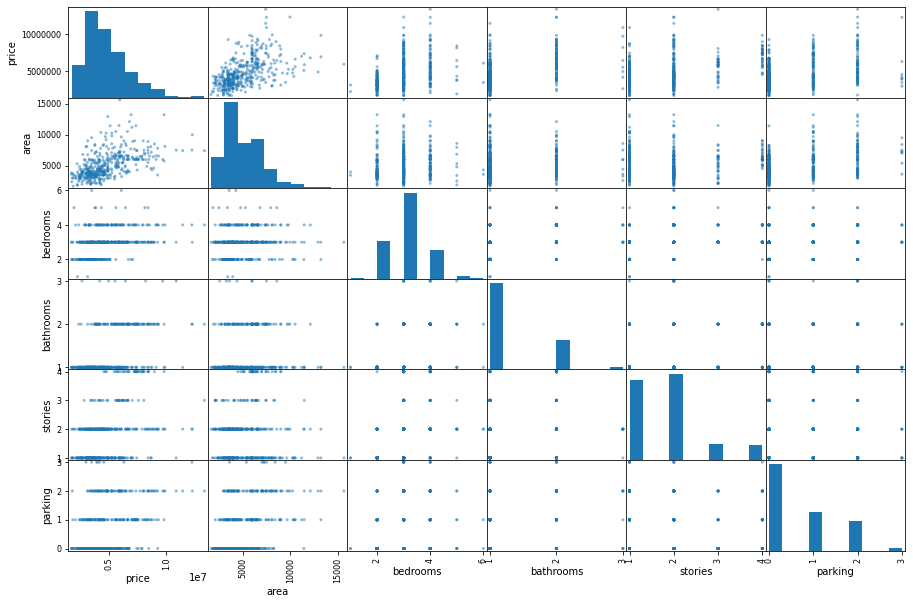

In [7]:
pd.plotting.scatter_matrix(train_data,figsize=(15,10))
plt.show()

In [8]:
train_data["log_price"] = np.log(train_data["price"])
train_data["log_area"] = np.log(train_data["area"])

Text(0, 0.5, 'Log Price')

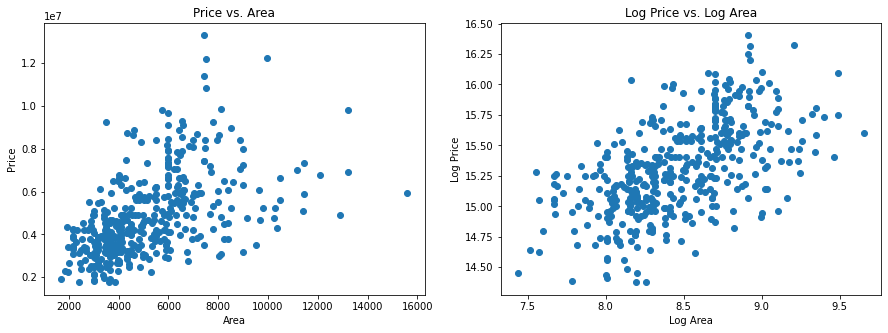

In [9]:
fig,ax = plt.subplots(nrows=1,ncols=2,figsize=(15,5))
ax[0].scatter(train_data["area"],train_data["price"])
ax[0].set_title("Price vs. Area")
ax[0].set_xlabel("Area")
ax[0].set_ylabel("Price")
ax[1].scatter(train_data["log_area"],train_data["log_price"])
ax[1].set_title("Log Price vs. Log Area")
ax[1].set_xlabel("Log Area")
ax[1].set_ylabel("Log Price")

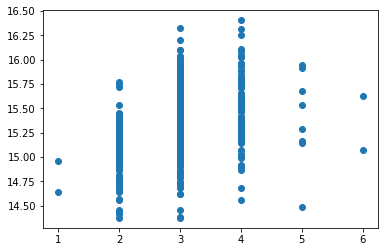

In [10]:
plt.scatter(train_data["bedrooms"],train_data["log_price"])

In [11]:
train_data.groupby("bedrooms")["price"].agg(Mean_millions = lambda x : np.mean(x)/100000,Count = "count")

,Mean_millions,Count
bedrooms,,
1,27.125000,2
2,35.612667,105
3,50.393972,239
4,57.502375,80
5,53.103750,8
6,47.915000,2


In [12]:
train_data.groupby("bathrooms")["price"].agg(Mean_millions = lambda x : np.mean(x)/100000,Count = "count")

,Mean_millions,Count
bathrooms,,
1,42.139009,318
2,63.937949,110
3,65.651250,8


In [13]:
train_data.groupby("parking")["price"].agg(Mean_millions = lambda x : np.mean(x)/100000,Count = "count")

,Mean_millions,Count
parking,,
0,41.412794,238
1,52.859813,107
2,60.592101,83
3,52.150000,8


### Creating Custom Transformers for Feature Selection

In [14]:
class log_transform(BaseEstimator,TransformerMixin):
    def fit(self,X,y=None):
        return self
    def transform(self,X,y=None):
        X["log_area"] = np.log(X["area"])
        return X

In [15]:
class bedrooms_coder(BaseEstimator,TransformerMixin):
    def fit(self,X,y=None):
        return self
    def transform(self,X,y=None):
        X["bedrooms_modified"] = np.where(X.loc[:,'bedrooms']<2,"<2",np.where(X.loc[:,"bedrooms"]>4,">4",X.loc[:,"bedrooms"]))
        return X

In [16]:
class bathrooms_coder(BaseEstimator,TransformerMixin):
    def fit(self,X,y=None):
        return self
    def transform(self,X,y=None):
        X["bathrooms_modified"] = np.where(X.loc[:,'bathrooms']>1,">1",X.loc[:,"bathrooms"])
        return X

In [17]:
class parking_coder(BaseEstimator,TransformerMixin):
    def fit(self,X,y=None):
        return self
    def transform(self,X,y=None):
        X["parking_modified"] = np.where(X.loc[:,'parking']>2,">2",X.loc[:,"parking"])
        return X

In [18]:
class column_selector(BaseEstimator,TransformerMixin):
    def __init__(self,columns_list):
        self.columns_list = columns_list
        self.feature_names_in_ = columns_list
    def fit(self,X,y=None):
        return self
    def transform(self,X):
        return pd.DataFrame(X[self.columns_list])
    def get_feature_names_out(self,feature_names=None):
        return self.columns_list

### Creating Pipelines for Linear Regression

In [19]:
X_train = train_data.drop("price",axis=1)
Y_train = np.log(train_data['price'])

In [20]:
features_selected = ['log_area','bedrooms_modified', 'bathrooms_modified', 'parking_modified','stories','mainroad',
       'guestroom', 'basement', 'hotwaterheating', 'airconditioning','prefarea', 'furnishingstatus']

In [21]:
features_transform = Pipeline([('log_area',log_transform()),("bedroom_transform",bedrooms_coder()),
                               ("bathroom_transform",bathrooms_coder()),("parking_transform",parking_coder()),
                               ("Column_selector",column_selector(features_selected))])

In [22]:
features_to_encode = ['bedrooms_modified', 'bathrooms_modified', 'parking_modified','stories','mainroad',
       'guestroom', 'basement', 'hotwaterheating', 'airconditioning','prefarea', 'furnishingstatus']
encoding_transform = Pipeline([("features_selector",column_selector(features_to_encode)),
                               ("encoder",OneHotEncoder(drop="first"))])

In [23]:
no_transform = Pipeline([("Columns_Selector",column_selector(["log_area"]))])
combined_encoding = FeatureUnion([("No_Transform",no_transform),("encoding_transform",encoding_transform)])
feature_extract = Pipeline([("feature_transform",features_transform),("combined_encoding",combined_encoding)])
lin_reg = Pipeline([('feature_extract',feature_extract),('regressor',LinearRegression())])

### Creating Pipelines for Polynomial Regression

In [24]:
poly_reg_pipe = Pipeline([("selection_for_poly",column_selector(["log_area"])),("Poly_features",PolynomialFeatures())])
combined_encoding_polyreg = FeatureUnion([("Poly_pipe",poly_reg_pipe),("encoding_transform",encoding_transform)])
feature_extract_poly = Pipeline([("feature_transform",features_transform),("combined_encoding",combined_encoding_polyreg)])
poly_reg = Pipeline([('feature_extract',feature_extract_poly),('regressor',LinearRegression(fit_intercept=False))])

### Creating Pipelines for Ridge & Lasso Regression

In [59]:
ridge_reg = Pipeline([('feature_extract',feature_extract_poly),('regressor',Ridge(fit_intercept=False))])
lasso_reg = Pipeline([('feature_extract',feature_extract_poly),('regressor',Lasso(fit_intercept=False,max_iter=5000))])

### Fitting all models with default Hyperparameters

In [60]:
lin_reg_model = lin_reg.fit(X_train,Y_train)
poly_reg_model = poly_reg.fit(X_train,Y_train)
ridge_reg_model = ridge_reg.fit(X_train,Y_train)
lasso_reg_model = lasso_reg.fit(X_train,Y_train)

### Coefficients of all the models

In [61]:
def get_coefficients(model):
    intercept = model[1].intercept_
    coefs = model[1].coef_
    encoder = model[0][1]
    col_names = []
    for i in encoder.named_transformers.keys():
        col_names.extend(encoder[i].get_feature_names_out())
    
    if col_names[0]!="1":
        coefs = np.insert(coefs,0,intercept)
        col_names.insert(0,"Intercept")
    else:
        col_names[0] = "Intercept"
    
    return pd.DataFrame(coefs.reshape((-1,1)),index=col_names,columns=[np.random.randint(0,100)])

In [62]:
def get_coef_table(model_list,column_names = None):
    coef_df = pd.DataFrame()
    for model in model_list:
        df = get_coefficients(model)
        coef_df = pd.concat([coef_df,df],axis=1)
    
    if column_names is not None:
        coef_df.columns = column_names
    return coef_df

In [63]:
get_coef_table([lin_reg_model,poly_reg_model,ridge_reg_model,lasso_reg_model],["Linear","Poly (degree=2)","Ridge","Lasso"])

,Linear,Poly (degree=2),Ridge,Lasso
Intercept,12.355129,5.618590,0.641770,0.000000
log_area,0.301503,1.895717,2.713144,0.000000
bedrooms_modified_3,0.103583,0.102736,0.149420,0.000000
bedrooms_modified_4,0.102905,0.100982,0.137104,0.000000
bedrooms_modified_<2,-0.024386,-0.035161,0.014227,0.000000
bedrooms_modified_>4,0.151544,0.156704,0.034489,0.000000
bathrooms_modified_>1,0.159492,0.155371,0.363407,-0.000000
parking_modified_1,0.075066,0.076486,-0.136375,-0.000000
parking_modified_2,0.106112,0.112447,-0.174348,-0.000000
parking_modified_>2,-0.058377,-0.052593,-0.146570,-0.000000


### Feature elimination property of Ridge and Lasso

In [64]:
def generate_ridge_pipe(l):
    ridge_reg = Pipeline([('feature_extract',feature_extract_poly),('regressor',Ridge(fit_intercept=False,alpha=l))])
    return ridge_reg

def generate_lasso_pipe(l):
    lasso_reg = Pipeline([('feature_extract',feature_extract_poly),('regressor',Lasso(fit_intercept=False,alpha=l))])
    return lasso_reg

In [65]:
l = np.linspace(0.1,2,11)
ridge_model_list = [generate_ridge_pipe(i).fit(X_train,Y_train) for i in l]
lasso_model_list = [generate_lasso_pipe(i).fit(X_train,Y_train) for i in l]
ridge_col_names = [f"Ridge (l={np.round(i,2)})" for i in l]
lasso_col_names = [f"Lasso (l={np.round(i,2)})" for i in l]

In [66]:
ridge_coef_table = get_coef_table(ridge_model_list,ridge_col_names)
lasso_coef_table = get_coef_table(lasso_model_list,lasso_col_names)

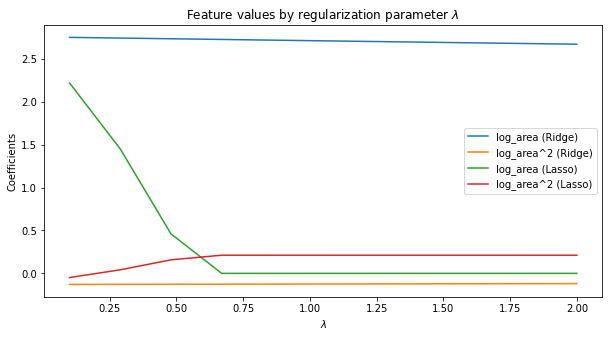

In [67]:
plt.figure(figsize=(10,5))
plt.plot(l,ridge_coef_table.T[["log_area","log_area^2"]],label = ["log_area (Ridge)","log_area^2 (Ridge)"])
plt.plot(l,lasso_coef_table.T[["log_area","log_area^2"]],label = ["log_area (Lasso)","log_area^2 (Lasso)"])
plt.legend()
plt.xlabel("$\lambda$")
plt.ylabel("Coefficients")
plt.title("Feature values by regularization parameter $\lambda$")
plt.show()

### Scores for all the models

In [68]:
mse_scorer = make_scorer(mean_squared_error,greater_is_better=False)
r2_scorer = make_scorer(r2_score)

In [69]:
def get_scores(model,X,y):
    mse =  -mse_scorer(model,X,y)
    r_2 = r2_scorer(model,X,y)
    rmse = mse**0.5
    adj_r_2 = 1-((1-r_2)*(X.shape[0]-1)/(X.shape[0] - X.shape[1]))
    
    return pd.DataFrame([mse,r_2,rmse,adj_r_2],index = ["MSE","R-sq","RMSE","Adj. R-sq"])

In [70]:
def get_score_df(model_list,X,Y,column_names = None):
    score_df = pd.DataFrame()
    for model in model_list:
        df = get_scores(model,X,Y)
        if score_df.empty:
            score_df = df
        else:
            score_df = pd.concat([score_df,df],axis=1)
    if column_names is not None:
        score_df.columns = column_names
    
    return score_df

In [71]:
get_score_df([lin_reg_model,poly_reg_model,ridge_reg_model,lasso_reg_model],X_train,Y_train,["Linear","Poly (degree=2)","Ridge","Lasso"])

,Linear,Poly (degree=2),Ridge,Lasso
MSE,0.041443,0.041125,0.086136,1.524144
R-sq,0.712708,0.714910,0.402882,-9.565717
RMSE,0.203575,0.202794,0.293490,1.234562
Adj. R-sq,0.701737,0.704024,0.380081,-9.969181


### HyperParameter Tuning

#### Polynomial Regression

In [72]:
poly_reg_cv = GridSearchCV(poly_reg,
             param_grid = {"feature_extract__combined_encoding__Poly_pipe__Poly_features__degree":[1,2,3,4,5]},
            scoring=mse_scorer,cv=10)

In [73]:
poly_reg_cv_results = poly_reg_cv.fit(X_train,Y_train)

In [74]:
pd.DataFrame(poly_reg_cv_results. cv_results_)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_feature_extract__combined_encoding__Poly_pipe__Poly_features__degree,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,split5_test_score,split6_test_score,split7_test_score,split8_test_score,split9_test_score,mean_test_score,std_test_score,rank_test_score
0,0.018903,0.001511,0.008403,0.000487,1,{'feature_extract__combined_encoding__Poly_pip...,-0.030423,-0.047253,-0.056508,-0.055600,-0.044745,-0.040757,-0.052084,-0.047704,-0.052991,-0.035312,-0.046338,0.008233,4
1,0.018005,0.000447,0.007499,0.000500,2,{'feature_extract__combined_encoding__Poly_pip...,-0.032780,-0.048641,-0.056402,-0.054302,-0.043829,-0.040550,-0.050431,-0.047898,-0.053968,-0.034367,-0.046317,0.007838,3
2,0.019405,0.001115,0.008306,0.000644,3,{'feature_extract__combined_encoding__Poly_pip...,-0.031691,-0.047757,-0.056392,-0.054276,-0.043784,-0.040634,-0.050590,-0.047727,-0.054137,-0.035689,-0.046268,0.007835,2
3,0.016804,0.000983,0.008498,0.000674,4,{'feature_extract__combined_encoding__Poly_pip...,-0.032473,-0.046851,-0.056332,-0.053952,-0.043288,-0.040549,-0.049819,-0.046831,-0.056004,-0.033511,-0.045961,0.008137,1
4,0.015601,0.000488,0.008413,0.000481,5,{'feature_extract__combined_encoding__Poly_pip...,-0.034216,-0.048546,-0.063243,-0.052832,-0.040292,-0.044484,-0.051067,-0.040312,-0.065333,-0.037060,-0.047739,0.010028,5


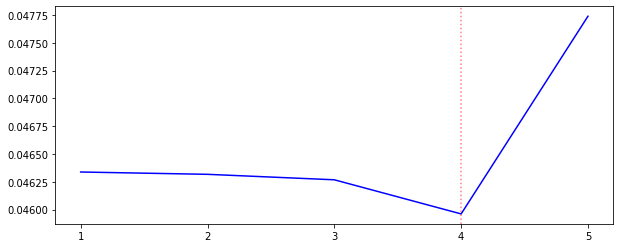

In [75]:
plt.figure(figsize=(10,4))
plt.plot([1,2,3,4,5],-poly_reg_cv_results.cv_results_['mean_test_score'],color="blue")
plt.axvline(x = list(poly_reg_cv_results.best_params_.values()),color="r",ls=":",alpha=0.5)
plt.xticks([1,2,3,4,5])
plt.show()

#### Ridge and Lasso

In [76]:
ridge_alpha_cv = RandomizedSearchCV(ridge_reg,
                                    param_distributions={"regressor__alpha":uniform(0.05,1)},
                                    scoring=mse_scorer,n_iter=20,cv=10)

In [77]:
lasso_alpha_cv = RandomizedSearchCV(lasso_reg,
                                    param_distributions={"regressor__alpha":uniform(0.05,1)},
                                    scoring=mse_scorer,n_iter=20,cv=10)

In [78]:
ridge_alpha_cv_results = ridge_alpha_cv.fit(X_train,Y_train)
lasso_alpha_cv_results = lasso_alpha_cv.fit(X_train,Y_train)

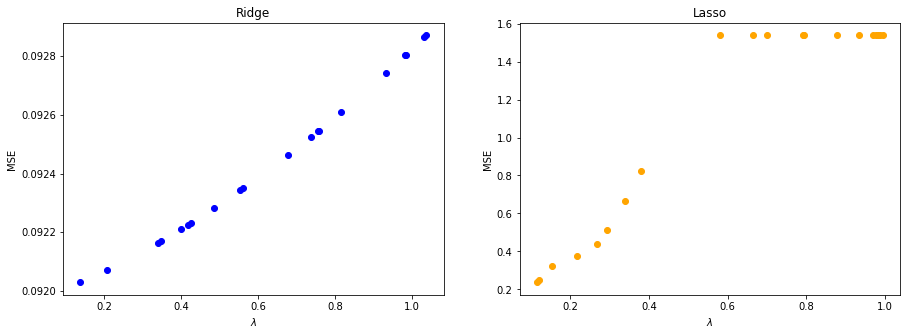

In [79]:
fig,ax = plt.subplots(nrows=1,ncols=2,figsize=(15,5))
result = pd.DataFrame(ridge_alpha_cv_results.cv_results_)
ax[0].scatter(result["param_regressor__alpha"],-result['mean_test_score'],color="blue")
ax[0].set_ylabel("MSE")
ax[0].set_xlabel("$\lambda$")
ax[0].set_title("Ridge")
result = pd.DataFrame(lasso_alpha_cv_results.cv_results_)
ax[1].scatter(result["param_regressor__alpha"],-result['mean_test_score'],color="orange")
ax[1].set_ylabel("MSE")
ax[1].set_xlabel("$\lambda$")
ax[1].set_title("Lasso")
plt.show()

In [86]:
param_grid = {"regressor__alpha":np.linspace(0.1,1,10),
              "feature_extract__combined_encoding__Poly_pipe__Poly_features__degree":[1,2,3,4,5]}

In [87]:
ridge_GridCV = GridSearchCV(ridge_reg,param_grid,cv=10,scoring=mse_scorer)
lasso_GridCV = GridSearchCV(lasso_reg,param_grid,cv=10,scoring=mse_scorer)

In [93]:
ridge_cv_results = ridge_GridCV.fit(X_train,Y_train)
lasso_cv_results = lasso_GridCV.fit(X_train,Y_train)

### Coefs and Scores of Best Estimators 

In [109]:
best_estimators = [poly_reg_cv_results.best_estimator_,lin_reg_model,ridge_cv_results.best_estimator_,lasso_cv_results.best_estimator_]

In [110]:
get_coef_table(best_estimators,["Poly (degree=4)","Linear","Ridge (degree=1, alpha=0.1)","Lasso (degree=4, alpha=0.1)"])

,Poly (degree=4),Linear,"Ridge (degree=1, alpha=0.1)","Lasso (degree=4, alpha=0.1)"
Intercept,0.078248,12.355129,10.608768,0.000000
log_area,0.329137,0.301503,0.507723,0.000000
log_area^2,0.914021,NaN,NaN,0.414097
log_area^3,-0.135646,NaN,NaN,-0.005921
log_area^4,0.005621,NaN,NaN,-0.002078
bedrooms_modified_3,0.100258,0.103583,0.118111,0.000000
bedrooms_modified_4,0.092443,0.102905,0.131702,0.000000
bedrooms_modified_<2,-0.023810,-0.024386,0.175377,-0.000000
bedrooms_modified_>4,0.129655,0.151544,0.097817,0.000000
bathrooms_modified_>1,0.155616,0.159492,0.164073,0.000000


In [112]:
get_score_df(best_estimators,X_train,Y_train,["Poly (degree=4)","Linear","Ridge (degree=1, alpha=0.1)","Lasso (degree=4, alpha=0.1)"])

,Poly (degree=4),Linear,"Ridge (degree=1, alpha=0.1)","Lasso (degree=4, alpha=0.1)"
MSE,0.041230,0.041443,0.047732,0.108490
R-sq,0.714186,0.712708,0.669109,0.247921
RMSE,0.203051,0.203575,0.218477,0.329379
Adj. R-sq,0.703272,0.701737,0.656473,0.219202


### Fitting best estimators on test data

In [114]:
X_test = test_data.drop("price",axis=1)
Y_test = np.log(test_data['price'])

In [115]:
get_score_df(best_estimators,X_test,Y_test,["Poly (degree=4)","Linear","Ridge (degree=1, alpha=0.1)","Lasso (degree=4, alpha=0.1)"])

,Poly (degree=4),Linear,"Ridge (degree=1, alpha=0.1)","Lasso (degree=4, alpha=0.1)"
MSE,0.037466,0.036668,0.049724,0.098738
R-sq,0.670244,0.677264,0.562359,0.130963
RMSE,0.193561,0.191490,0.222988,0.314225
Adj. R-sq,0.617058,0.625210,0.491772,-0.009204


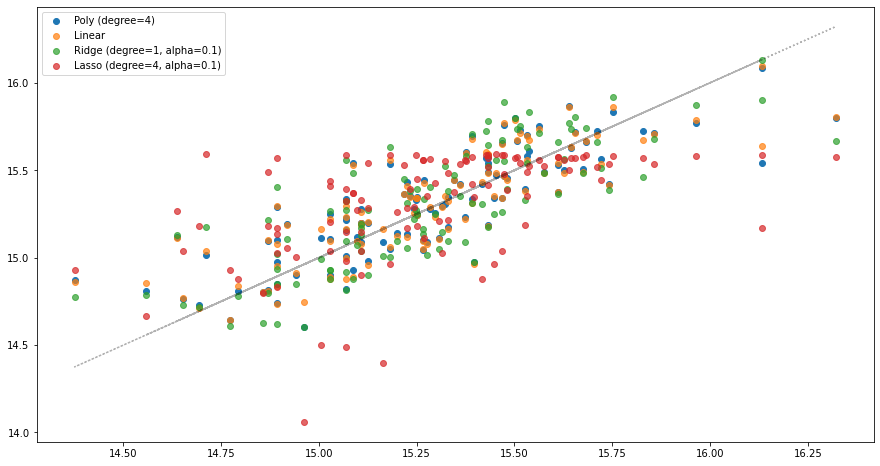

In [126]:
plt.figure(figsize=(15,8))
plt.scatter(Y_test,best_estimators[0].predict(X_test),label ="Poly (degree=4)")
plt.scatter(Y_test,best_estimators[1].predict(X_test),alpha=0.7,label ="Linear")
plt.scatter(Y_test,best_estimators[2].predict(X_test),alpha=0.7,label = "Ridge (degree=1, alpha=0.1)")
plt.scatter(Y_test,best_estimators[3].predict(X_test),alpha=0.7,label = "Lasso (degree=4, alpha=0.1)")
plt.plot(Y_test,Y_test,color = "black",ls = ":",alpha=0.3)
plt.legend()
plt.show()